In [22]:
%matplotlib inline

In [23]:
import numpy as np
import tensorflow as tf
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from server import fake_connection
import cv2

Gather the contour points according to a min and max thresh for the area of contours.

In [24]:
THRESH1 = 96
THRESH2 = 140
CONTOUR_MIN = 756
CONTOUR_MAX = 2277

frame_width = None
frame_hight = None

gathering_points = True
all_contours = None
max_points = 100000

# While number of points collects is insufficient
while gathering_points:
    for frame in fake_connection():

        # Saved frame dimensions
        if frame_width is None:
            frame_height, frame_width, _ = frame.shape

        # Apply open cv2 image transmformations for contour detection
        blurred = cv2.GaussianBlur(frame, (7, 7), 2)
        gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
        canny = cv2.Canny(gray, THRESH1, THRESH2)
        kernel = np.ones((5,5))
        dilated = cv2.dilate(canny, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        for contour in contours:

            # Filter by min and max areas of contours
            area = cv2.contourArea(contour)
            if area > CONTOUR_MIN and area < CONTOUR_MAX:

                # Init np.array for all_contours
                if all_contours is None: all_contours = np.array(contour)

                else:
                    if len(all_contours) >= max_points:
                        gathering_points = False
                        break
                    
                    else:
                        all_contours = np.append(all_contours, contour, axis=0)
        
        if not gathering_points: break

drawable = all_contours
all_contours = all_contours.reshape((-1, 2))

Given the list of all points gathered, perform Kmeans clustering

In [25]:
# Initialize centroids

def find_closest_centroid(X, centroids):
    indices = np.zeros(X.shape, dtype=int)

    for i in range(X.shape[0]):
        distances = []
        for j in range(centroids.shape[0]):
            norm = np.linalg.norm(X[i] - centroids[j])
            distances.append(norm)
        
        indices[i] = np.argmin(distances)

    return indices

def update_centroid(X, indicies, K):
    m, n = X.shape
    centroids = np.zeros((K, n))

    for k in range(K):
        points = X[indicies==k]
        centroids[k] = np.mean(points, axis=0)

    return centroids

centroids = np.array([[1,1], [300, 300]])
history = []
# Run KMeans
m, n = all_contours.shape

K = len(centroids)
indicies = np.zeros(m)

max_iter = 20

for i in range(max_iter):
    indicies = find_closest_centroid(all_contours, centroids)
    history.append(centroids)
    centroids = update_centroid(all_contours, indicies, K)

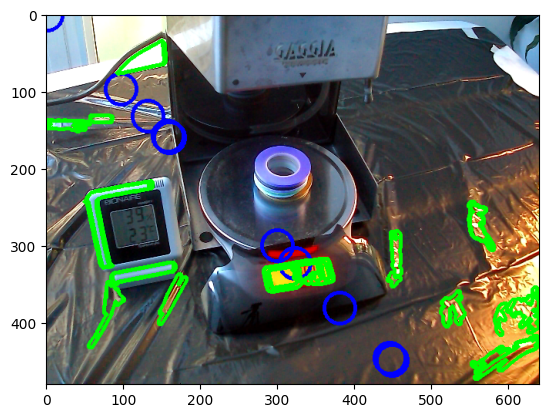

In [28]:

for _centroids in history:
    for centroid in _centroids:
        centroid = tuple(np.uint32(centroid))
        cv2.circle(frame, centroid, 20, (0, 0, 255), 3)

for centroid in centroids:
    centroid = tuple(np.uint32(centroid))
    cv2.circle(frame, centroid, 20, (0, 0, 255), 3)


cv2.drawContours(frame, drawable, -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(frame)